## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 1: Let's GOOOOO!

- **100 points [7% of your final grade]**
- **Due Tuesday, February 13 by 11:59pm**

***Goals of this homework:***
1. Collect data from the web, clean it, and then make some observations based on exploratory data analysis
2. Understand and implement the classic apriori algorithm and extensions to find the association rules in a movie rating dataset

***Submission instructions:***

You should post your notebook to Canvas (look for the homework 1 assignment there). Please name your submission **your-uin_hw1.ipynb**, so for example, my submission would be something like **555001234_hw1.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. 

***Late Days:***

As a reminder, you may use up to three of your late days on this homework, meaning the latest we will accept it is February 16 by 11:59pm.

***Collaboration declaration:***

If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

## (50 points) Part 1: UFOs

### (10pts) Part 1a: UFOs are Out There, But First I Need to Store them Locally

For this first part, we're going to collect evidence of UFO sightings from the **National UFO Reporting Center**. Specifically, we're going 
to focus only on UFO sightings in Texas, as reported at this webpage:

* http://www.nuforc.org/webreports/ndxlTX.html

Recall that you can view the source of a webpage in Chrome under View &rarr; Developer &rarr; View Source. 
You'll notice, however, that this raw HTML is not in our friendly csv format and so will require some initial pre-processing. 
In particular, we're going to use the Python libraries **[requests](http://docs.python-requests.org/en/master/)** 
and **[beautiful soup](https://www.crummy.com/software/BeautifulSoup/)** to convert this UFO data from its original HTML format into csv. 

Hints:
* You'll notice that the column headers are in the `<TH>` tags.
* The values are in the `<TD>` tags.
* In beautiful soup, something like `.find_all('td')` may help you.
* To write the csv, you might want to `import csv` and take a look at the functions provided.
* If you google for "beautifulsoup table to csv" you should find some nice starting points.  Note, however, that you may not use an existing method that auto-magically converts the HTML into csv; we expect you to write your own code. If you borrow some elements from online resources, you should cite them in the comments. 

In [1]:
# your code here
# you should use requests to get the webpage, then extract 
# the appropriate column headings and rows
#Ref : https://www.geeksforgeeks.org/convert-html-table-into-csv-file-in-python/
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv
import numpy as np

page = requests.get("http://www.nuforc.org/webreports/ndxlTX.html")

soup = BeautifulSoup(page.text, 'html.parser')

count=1
table ={}
columnNames = []
    
for row in soup.find_all('tr'):
    temp = []
    for c in row.find_all('th'):
        columnNames.append(c.text)
        temp.append(c.text)
    for c in row.find_all('td'):
        temp.append(c.text)
    table[count]=temp
    count+=1
# then write this out to csv to a local file called 'ufos_in_texas.csv'

Once you have your local csv file, you should read it in and then issue the .head() command.

In [2]:
df=pd.DataFrame.from_dict(table,orient='index',columns = columnNames)
df = df.drop(1) #delete row that is a copy of the column names
#save dataframe to a csv file
df.to_csv (r'ufo_texas.csv', index = None, header=True)
# your code here

data = pd.read_csv("ufo_texas.csv")
data.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8 minutes,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10 minutes,A light that was fading in and out.,12/19/21
2,12/9/21 16:30,Lazerbet,TX,Other,Google maping,It's big,12/19/21
3,12/9/21 16:00,Lazerbet,TX,Triangle,NaN,Unhuman,12/19/21
4,12/7/21 17:30,Oak Cliff,TX,Unknown,NaN,I was randomly taking pictures of the clouds a...,12/19/21


### (15pts) Part 1b: UFOs are a Mess! Time to Clean Up!

Okay, now we move to the fun part -- making sense of this messy data. These UFO reports are user-generated with little input validation. As a result, you will notice lots of oddities. 

Let's begin by focusing on the **Duration** column. As a first pass, let's make a grossly simplifying assumption -- that the only valid data is any duration that is of the form:  

* 1 second
* 2 seconds
* ...
* 1 minute
* 2 minutes
* ...
* 1 hour
* 2 hours 
* ...
* 1 day
* 2 days 
* ...

That is, we will only accept positive integers followed by a space, followed by a properly spelled unit. Every other entry is invalid. For example, that means these are all invalid durations:

* 1s
* 2 min.
* 2-3 seconds
* 10-15min
* 1 minute+
* 30 minutes and longer
* about 1.5 minutes

You may find the **pandas** library to be very helpful for this part. Create a new pandas dataframe that only includes sightings with these values, **where you convert all durations into seconds**. How many total rows are there in the original dataset? How many rows in your new 'validated' dataset? Report the basic statistics of the duration in your new 'validated' dataset (report maximum, minimum, mean, and standard deviation values of duration). At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

In [3]:
Copy_data = data.copy(deep=True)
import re

def check_valid(z):
    z = re.match('^\d+\s+(second|seconds|minute|minutes|hour|hours|day|days|week|weeks)',z)
    if('None' not in str(type(z))):
        return(z.group(0))

#removing invalid durations
def Clean_data(data):
    valid_data = []
    for i,row in data.iterrows():
        if(type(row['Duration'])!='float'):
            if check_valid(str(row['Duration'])):
                valid_data.append(i)
    return valid_data

rows = Clean_data(Copy_data)

for index, row in Copy_data.iterrows():
    if index not in rows:
        Copy_data.drop(index,inplace=True)
                

In [4]:
# your code here
# total rows in original dataset
print("Original Dataset",data.shape)
# valid rows in your new 'validated' dataset
print("Validated Dataset",Copy_data.shape)

#Convert duration to seconds
for index,row in Copy_data.iterrows(): 
    res = [int(i) for i in str(row['Duration']).split() if i.isdigit()]
    if 'minute' in row['Duration']:
        row['Duration'] = str(60*res[0]) + " " + "seconds"
    if 'hour' in row['Duration']:
        row['Duration'] = str(60*60*res[0]) + " " + "seconds"
    if 'day' in row['Duration']:
        row['Duration'] = str(24*60*60*res[0]) + " " + "seconds"
    if 'week' in row['Duration']:
        row['Duration'] = str(7*24*60*60*res[0]) + " " + "seconds"

Copy_data.head()

Original Dataset (5631, 7)
Validated Dataset (2902, 7)


,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,480 seconds,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,600 seconds,A light that was fading in and out.,12/19/21
14,11/6/21 14:00,Abilene,TX,Changing,1800 seconds,"I was outside waiting on my ride, when a white...",11/15/21
16,10/25/21 17:18,Corpus Christi,TX,Other,2400 seconds,Seven United States Postal workers in Corpus C...,10/26/21
18,10/23/21 03:30,Garland,TX,Light,25200 seconds,Early morning site & short encounter,11/15/21


Maximum duration:  604800.0
Minimum duration:  1.0
SD duration:  15489.052057113999


{'whiskers': [<matplotlib.lines.Line2D at 0x1271dfe90>,
 'caps': [<matplotlib.lines.Line2D at 0x1271e9910>,
 'boxes': [<matplotlib.lines.Line2D at 0x1271a9990>],
 'medians': [<matplotlib.lines.Line2D at 0x1271dff50>],
 'fliers': [<matplotlib.lines.Line2D at 0x1271ef890>],
 'means': []}

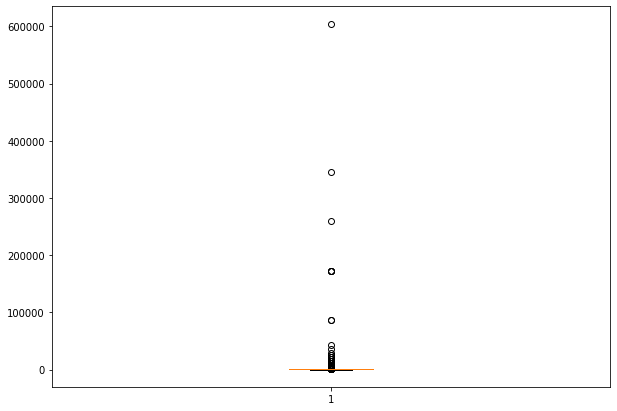

In [6]:
# your code here
# report the basic statistics of duration in 'validated' dataset
#array of durations
#Statistics
#report maximum, minimum, mean, and standard deviation values of duration
def Calculate_stat(dataset):
    durations=[]
    temp = dataset['Duration']
    for t in temp:
        t = t.split()[0]
        durations.append(float(t.split()[0]))
    print("Maximum duration: ",max(durations))
    print("Minimum duration: ",min(durations))
    print("SD duration: ",np.std(durations))
    
    return durations

durations = Calculate_stat(Copy_data)

# boxplot code here
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(durations)

### (15pts) Part 1c: Can we do better?
Interesting. But we threw away a **lot** of data. We can do better. For this part, you will do your best to clean up the durations from your original dataset. Keep in mind some initial guidelines:

* If a duration has a range, use the average as its value. For example, if the duration is listed as “6-8 minutes”, you should consider the duration as “7 minutes”. (Again, you will need to eventually convert minutes into seconds).
* If a duration has a “<” sign, you should simply ignore the “<” sign. For example if the duration is specified as “< 1 minute”, consider the duration to be “1 minute”. You should subsequently convert “1 minute” to "60 seconds".
* If a duration has a “>” sign, you should simply ignore the “>” sign. 
* You should ignore any row with an empty duration.

You will probably have to improvise as you go along, so **make detailed notes of what decisions you are making and why**.

In [7]:
# your code here 
#Copy data
valid_data = data.copy(deep=True)
valid_data.head(500)

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8 minutes,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10 minutes,A light that was fading in and out.,12/19/21
2,12/9/21 16:30,Lazerbet,TX,Other,Google maping,It's big,12/19/21
3,12/9/21 16:00,Lazerbet,TX,Triangle,NaN,Unhuman,12/19/21
4,12/7/21 17:30,Oak Cliff,TX,Unknown,NaN,I was randomly taking pictures of the clouds a...,12/19/21
...,...,...,...,...,...,...,...
495,10/12/19 17:10,Irving,TX,Light,30 seconds,pulsating orange / white light hovering,12/1/19
496,10/12/19 16:41,Pflugerville,TX,Oval,?,Short Rainbow with a vortex appearing cloud an...,12/1/19
497,10/12/19 08:00,Tomball,TX,Cigar,60 seconds,cigar shaped object streaking across the sky. ...,12/1/19
498,10/11/19 19:49,Allen,TX,Light,less than 1 minute,White light following ISS,12/1/19


In [8]:
valid_data.shape

(5631, 7)

In [9]:
# your code here 
Sec = {'s','sec','secs','second','seconds'}
Min = {'m','min','mins','minute','minutes'}
Hour = {'h','hrs','hour','hours'}
Day =  {'day','days'}
Week = {'week','weeks'}

start = r'(?:\<|\>|\~|\+|plus|approx\.|about|approx|approximately|\,|less than|\?)' 
between = r'(\-|to|\/|and|\&|or)+'
r1 = r'^(\d+)\s*(mins?|hours?|secs?|hrs?|m|s|h|minutes?|seconds?|days?|weeks?)'
r2 = r'^'+ start + r'\s*(\d+)\s*(mins?|hours?|secs?|hrs?|m|s|h|minutes?|seconds?|days?|weeks?)'
r3 = r'^'+ start+ r'?' +'(\d+)\s*' + between + r'\s*(\d+)\s*(mins?|hours?|secs?|hrs?|m|s|h|minutes?|seconds?|days?|weeks?)' 
r4 = r'^'+ start + r'?' + '(\d+)\s*(mins?|hours?|secs?|hrs?|m|s|h|minutes?|seconds?|days?|weeks?)'+ r'\s*' + between + r'\s*(\d+)\s*(mins?|hours?|secs?|hrs?|m|s|h|minutes?|seconds?|days?|weeks?)'


#For regex r1 and r2
def convert_to_sec(exp):
    if (set(exp[1].lower()) & Sec):
        return str(int(exp[0])) + ' seconds'
    elif (set(exp[1].lower()) & Min):
        return str(60*int(exp[0])) + ' seconds'
    elif (set(exp[1].lower()) & Hour):
        return str(60*60*int(exp[0])) +' seconds'
    elif (set(exp[1].lower()) & Day):
        return str(24*60*60*int(exp[0]))+' seconds'
    else:
        return str(7*24*60*60*int(exp[0]))+' seconds'

#For regex r3 and r4     
def range_to_sec(exp):
    if len(exp)==4:
        c = float((int(exp[0])+int(exp[2]))/2)
        if exp[3].lower() in Sec:
            z=str(c)+ ' seconds'
        elif exp[3].lower() in Min:
            z=str(int(60*c))+ ' seconds'
        elif exp[3].lower() in Hour:
            z=str(int(60*60*c))+ ' seconds'
        elif exp[3].lower() in Day:
            z=str(int(24*60*60*c))+ ' seconds'
        else:
            z=str(int(7*24*60*60*c))+ ' seconds'
        return z
    

import types

def Validation_Set(data):
  
    New_R = set()
    for index,row in data.iterrows(): 
        if 'float' not in str(type(row['Duration'])):
            
            duration  = str(row['Duration'])
           
            #Eg : 1 seconds
            exp1 = re.search(r1,duration,re.I)
            if exp1 is not None:
                update = convert_to_sec(exp1.groups())
                valid_data.iloc[index]['Duration'] = update
                New_R.add(index)
            
            #Eg: about 1 minutes
            exp2 = re.search(r2,duration,re.I)
            if exp2 is not None:
                update = convert_to_sec(exp2.groups())
                valid_data.iloc[index]['Duration'] = update
                New_R.add(index)
            
            #Eg: 2-3 seconds    
            exp3 = re.search(r3,duration,re.I)
            if exp3 is not None:
                update = range_to_sec(exp3.groups())
                valid_data.iloc[index]['Duration'] = update
                New_R.add(index)
            
            #Eg: 10min-15min   
            exp4 = re.search(r4,duration,re.I)
            if exp4 is not None:
                update = range_to_sec(exp4.groups())
                valid_data.iloc[index]['Duration'] = update
                New_R.add(index)
    return New_R

rows = list(Validation_Set(valid_data))

for index, row in valid_data.iterrows():
    if index not in rows:
        valid_data.drop(index,inplace=True)
print(valid_data.shape)

valid_data.head()

(4609, 7)


,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,480 seconds,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,600 seconds,A light that was fading in and out.,12/19/21
5,12/3/21 21:00,Sanderson,TX,Light,60 seconds,Sighting of odd light in night sky.,12/19/21
12,11/12/21 10:00,Hickory Creek,TX,Circle,150 seconds,2 identical circular orange spheres traveling ...,11/15/21
14,11/6/21 14:00,Abilene,TX,Changing,1800 seconds,"I was outside waiting on my ride, when a white...",11/15/21


In [10]:
valid_data = valid_data.replace(to_replace='None', value=np.nan).dropna() #remove null values
valid_data.head()
valid_data.shape


(4511, 7)

Maximum duration:  604800.0
Minimum duration:  1.0
SD duration:  15628.827083868035


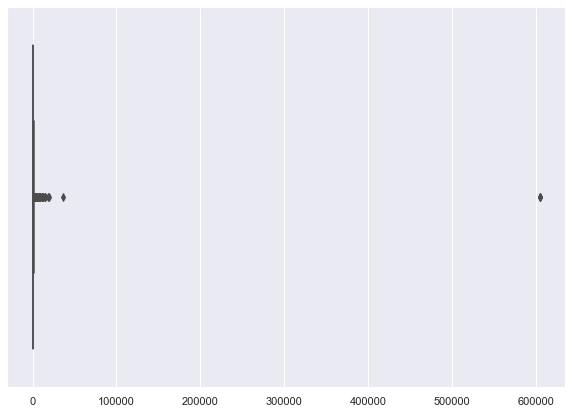

In [11]:
# your code here
# report the basic statistics of duration in your cleaned dataset
New_durations = Calculate_stat(valid_data)
import matplotlib.pyplot as plt
import numpy as np
 
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
# draw a boxplot for your cleaned dataset
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.boxplot(New_durations)
plt.show()

### (5pts) Part 1d: Observations and Conclusions

Based on your analysis on part 1b and 1c, what observations or conclusions can you make from the data?

*In part 1b a lot of data was wasted and around 50% of data was wasted
According to the boxplot from part 1b values were more spread out and they were close to minimum value and because of that the SD is 
In part 1c i.e validation data only around 23% of data was wasted
Here the time for each row is more close to minimum value and because of that the SD is 15628*

### (5pts) Part 1e: Next Steps

Now is your chance to conduct an interesting analysis on the UFO data you have collected. This is open-ended, so you may choose whatever direction you like. For example, you might want to take a look at the shape of the UFOs or perhaps the temporal aspects of the reports. 

Top 10 Shapes:


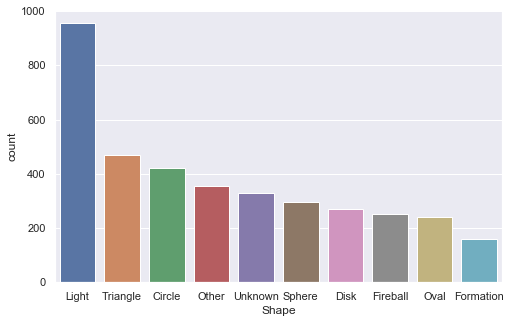

In [12]:
import seaborn
print('Top 10 Shapes:')
plt.subplots(figsize=(8,5))
seaborn.countplot(x="Shape", data=valid_data,
                  order=pd.value_counts(valid_data['Shape']).iloc[:10].index)
plt.show()

Occurance of all shapes:


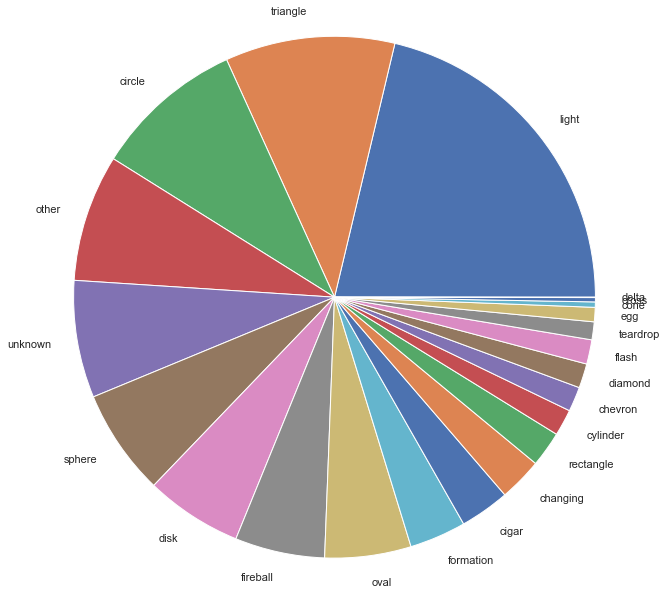

In [13]:
# your code here
from matplotlib.pyplot import pie, axis, show
shp = valid_data['Shape'].str.lower().value_counts()
print('Occurance of all shapes:')
pie(shp, labels=shp.index,radius=3);
show()


*The most occured shape is Light. Both 'Light' and 'light' was combined into 1 category.*

## (50 points) Part 2: Association Rules in Movie Rating Behaviors

For the second part of this homework, we're going to examine movies using our understanding of association rules, to find movies that "go together". For this part, you will implement the apriori algorithm, and apply it to a movie rating dataset. We'll use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset.

First, run the next cell to load the dataset we are going to use.

In [14]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [15]:
!ls ml-latest-small/

README.txt  links.csv   movies.csv  ratings.csv tags.csv


In this dataset, there are four columns: `userId` is the integer ids of users, `movieId` is the integer ids of movies, `rating` is the rate of the user gives to the movie, and `timestamp` which we do not use here. Each row denotes that the user of given `userId` rated the movie of the given `movieId`. We are going to treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket. 

Now, you need to implement the apriori algorithm and apply it to this dataset to find association rules of user rating behaviors where:

1. Define `rating` >= 3 is "like" (that is, only consider movie ratings of 3 or higher in your baskets; you may ignore all others)
2. `minsup` == 40 (out of 600 users/baskets); we may adjust this based on the discussion on Campuswire
3. `minconf` == to be determined by a discussion on Campuswire. You may try several different choices, but we will converge on a good choice for everyone for the final submission.
 
We know there are many existing implementations of apriori online (check github for some good starting points). You are welcome to read existing codebases and let that inform your approach. Do not copy-paste any existing code. We want your code to have sufficient comments to explain your steps, to show us that you really know what you are doing. Furthermore, you should add print statements to print out the intermediate steps of your method -- e.g., the size of the candidate set at each step of the method, the size of the filtered set, and any other important information you think will highlight the method. 

To help get you started, we can load the ratings with the following code snippet:

In [16]:
import pandas as pd
from itertools import combinations
# read user ratings
allRatings = pd.read_csv("ml-latest-small/ratings.csv")
allRatings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### (15pts) Step 1: Implement Apriori Algorithm
In this section, you need to implement the Apriori algorithm, we will check the correctness of your code and we encourage efficient implementation and skills of pruning.

In [17]:
# your code here
#Ref : https://github.com/coorty/apriori-agorithm-python/blob/master/apriori.py
#Ref : http://www.vucreations.com/articles/apriori-algorithm-from-scratch-Python.html
# your code here
min_sup = 0.25 
min_confidence = 0.9
baskets = {} 

def create_basket(df):
    movies = set()
    basket = {}
    for row in df.iterrows():
        userId = row[1]['userId']
        movieId = row[1]['movieId']
        movies.add(movieId)
        
        if userId in basket:
            basket[userId].add(movieId)
        else:
            basket[userId]={ movieId }
    return basket

baskets = create_basket(allRatings)


from itertools import combinations

#takes a list of tuples of item combinations and returns list of frequent itemset
def getFrequentItems(combos,min_support,basket,itemset):
    frequent_items = []
    for combo in combos:
        count=0
        #Calculate support
        for UID in basket:
            if set(combo).issubset(basket[UID]):
                count+=1
        
        if count/len(basket) >= min_support:
            frequent_items.append(combo)
            itemset.append(combo)
            
    return frequent_items

#returns a list of frequent items
#Eg : [(A,B),(B,C)] => {A,B,C}
def getCombinations(frequent_items, size):
    frequent_itemset = set()
    for items_tuple in frequent_items:
        for item in items_tuple:
            frequent_itemset.add(item)
    
    combos = list(combinations(frequent_itemset, size))
    return combos

#returns confidence of an event happening
#Confidence(A->B)=support(AUB)/support(A)
def getConfidence(intersection, condition,basket):
    int_c = 0
    cond_c = 0
    #Caluculate support
    #Count total occurances in the basket
    for Id in basket:
        if intersection.issubset(basket[Id]):
            int_c+=1
        if condition.issubset(basket[Id]):
            cond_c +=1
    
    return int_c / cond_c


def findRules(frequent_items, association_rules,basket):
    for item_tuple in frequent_items:
        itemset = set(item_tuple)
        for item in itemset:
            condition = itemset - {item}
            #scanning itemset for counting support
            if getConfidence(itemset,condition,basket) >= min_confidence:
                association_rules.append((condition, item))

itemset_whole = []
def apriori(basket,min_sup,itemset):
    if len(basket) == 0:
        return set()
    
    association_rules = []
    frequent_item_count = 0
    level = 0
    # Get all items into one set
    all_itemset = set()
    for key in basket:
        all_itemset = all_itemset.union(basket[key])
    item_tuples = [ (item,) for item in all_itemset ]
    
    frequent_items = getFrequentItems(item_tuples,min_sup,basket,itemset)
    #itemset.append(frequent_items)
    level+=1
    print(len(frequent_items),'itemset')
    print(frequent_items)
    print()
    frequent_item_count+=len(frequent_items)    
    while len(frequent_items) > 0:
 
        # Extract all subsets with higher value of support than min support
        combo = getCombinations(frequent_items, level)
        level+=1
        #Calculate frequent itemset
        frequent_items = getFrequentItems(combo,min_sup,basket,itemset)
        print(len(frequent_items),'itemset')
        #itemset.append(frequent_items)
        print(frequent_items)
        print()
        frequent_item_count+=len(frequent_items)
        #find association rules form support
        findRules(frequent_items, association_rules,basket)
    
    print('Frequent itemset count:',frequent_item_count)
    return association_rules

association_rules = apriori(baskets,min_sup,itemset_whole)

print('Association Rules:', association_rules)    



43 itemset
[(1.0,), (32.0,), (47.0,), (50.0,), (110.0,), (150.0,), (260.0,), (296.0,), (318.0,), (344.0,), (356.0,), (364.0,), (367.0,), (377.0,), (380.0,), (457.0,), (480.0,), (527.0,), (588.0,), (589.0,), (590.0,), (592.0,), (593.0,), (608.0,), (648.0,), (780.0,), (858.0,), (1196.0,), (1198.0,), (1210.0,), (1270.0,), (1580.0,), (2028.0,), (2571.0,), (2762.0,), (2858.0,), (2959.0,), (3578.0,), (4226.0,), (4306.0,), (4993.0,), (5952.0,), (7153.0,)]

43 itemset
[(1.0,), (4226.0,), (4993.0,), (260.0,), (648.0,), (2571.0,), (780.0,), (527.0,), (2959.0,), (150.0,), (32.0,), (296.0,), (2858.0,), (1196.0,), (1580.0,), (1198.0,), (47.0,), (50.0,), (1210.0,), (318.0,), (5952.0,), (457.0,), (2762.0,), (588.0,), (589.0,), (590.0,), (592.0,), (593.0,), (4306.0,), (344.0,), (858.0,), (480.0,), (608.0,), (356.0,), (364.0,), (2028.0,), (110.0,), (367.0,), (7153.0,), (1270.0,), (377.0,), (3578.0,), (380.0,)]

52 itemset
[(1.0, 356.0), (4993.0, 2571.0), (4993.0, 5952.0), (4993.0, 7153.0), (260.0, 2571

### (5pts) Step 2: Print Your Association Rules

Next you should print your final association rules in the following format:

**movie_name_1, movie_name_2, ... --> 
movie_name_k**

where the movie names can be fetched by joining the movieId with the file `movies.csv`. For example, one rule that you might find is:

**Matrix, The (1999),  Star Wars: Episode V - The Empire Strikes Back (1980),  Star Wars: Episode IV - A New Hope (1977),  -> 
Star Wars: Episode VI - Return of the Jedi (1983)**

In [18]:
df = pd.read_csv('movies.csv')

df.head()

new_association_rules = []
for rule in association_rules:
    # rule: ({movies}, movie)
    movie_names = { df.loc[df['movieId'] == movieId]['title'].values[0] for movieId in rule[0] }
    new_association_rules.append(','.join(movie_names)+'-->'+df.loc[df['movieId'] == rule[1]]['title'].values[0])
    

for rule in new_association_rules:
    print(rule)

Star Wars: Episode V - The Empire Strikes Back (1980)-->Star Wars: Episode IV - A New Hope (1977)
Lord of the Rings: The Fellowship of the Ring, The (2001),Lord of the Rings: The Return of the King, The (2003)-->Lord of the Rings: The Two Towers, The (2002)
Lord of the Rings: The Two Towers, The (2002),Lord of the Rings: The Return of the King, The (2003)-->Lord of the Rings: The Fellowship of the Ring, The (2001)
Lord of the Rings: The Two Towers, The (2002),Lord of the Rings: The Fellowship of the Ring, The (2001)-->Lord of the Rings: The Return of the King, The (2003)
Matrix, The (1999),Star Wars: Episode V - The Empire Strikes Back (1980)-->Star Wars: Episode IV - A New Hope (1977)
Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode V - The Empire Strikes Back (1980)-->Star Wars: Episode IV - A New Hope (1977)
Pulp Fiction (1994),Jurassic Park (1993)-->Forrest Gump (1994)


### (15pts) Step 3: Implement Random Sampling

We discussed in class a method to randomly sample baskets to avoid the overhead of reading the entire set of baskets (which in practice, could amount to billions of baskets). For this part, you should implement such a random sampling approach that takes a special parameter **alpha** that controls the size of the sample: e.g., alpha = 0.10 means to sample 10% of the baskets (our users, in this case). 

Vary **alpha** and report the number of frequent itemsets you find and how this compares to the number of frequent itemsets in the entire dataset. What do you discover?


In [19]:
import random

def random_sampling(percent,df):
    a = df['userId'].unique()
    alpha = len(a)*percent
    #print(len(df['userId']))
    unique_id = random.sample(list(a),int(alpha))
    #print(unique_id)
    new_df = df.loc[df['userId'].isin(unique_id)]
    #print(new_df)
    return new_df

new_df = random_sampling(0.05,allRatings)
new_basket = create_basket(allRatings)

sampling_itemset = []
apriori(new_basket,0.25,sampling_itemset)

42 itemset
[(1.0,), (32.0,), (47.0,), (50.0,), (110.0,), (150.0,), (260.0,), (296.0,), (318.0,), (344.0,), (356.0,), (364.0,), (377.0,), (380.0,), (457.0,), (480.0,), (527.0,), (588.0,), (589.0,), (590.0,), (592.0,), (593.0,), (608.0,), (648.0,), (780.0,), (858.0,), (1196.0,), (1198.0,), (1210.0,), (1270.0,), (1580.0,), (2028.0,), (2571.0,), (2762.0,), (2858.0,), (2959.0,), (3578.0,), (4226.0,), (4306.0,), (4993.0,), (5952.0,), (7153.0,)]

42 itemset
[(1.0,), (4226.0,), (4993.0,), (260.0,), (648.0,), (2571.0,), (780.0,), (527.0,), (2959.0,), (150.0,), (32.0,), (296.0,), (2858.0,), (1196.0,), (1580.0,), (1198.0,), (47.0,), (50.0,), (1210.0,), (318.0,), (5952.0,), (457.0,), (2762.0,), (588.0,), (589.0,), (590.0,), (592.0,), (593.0,), (4306.0,), (344.0,), (858.0,), (480.0,), (608.0,), (356.0,), (364.0,), (2028.0,), (110.0,), (7153.0,), (1270.0,), (377.0,), (3578.0,), (380.0,)]

39 itemset
[(4993.0, 5952.0), (4993.0, 7153.0), (260.0, 2571.0), (260.0, 1196.0), (260.0, 1198.0), (260.0, 1210.

[({1196.0}, 260.0), ({1196.0, 2571.0}, 260.0)]

The number of frequent itemsets decreased for values of alpha <=5%. However for values of alpha > 5%, the number of frequent itemsets is same as the original dataset. However it did'nt decreased much.
Frequent itemset in original dataset = 142

For alpha = 0.05, count = 127

   alpha = 0.02, count = 125

### (10pts) Step 4: Check for False Positives

Next you should verify that the candidate pairs you discover by random sampling are truly frequent by comparing to the itemsets you discover over the entire dataset. 

For this part, consider another parameter **minsup_sample** that relaxes the minimum support threshold. For example if we want minsup = 1/100 for whole dataset, then try minsup_sample = 1/125 for the sample. This will help catch truly frequent itemsets.

Vary **minsup_sample** and report the number of frequent itemsets you find and the number of false positives you find. What do you discover?


In [20]:
# your code here
min_sup_itemset = []
apriori(new_basket,0.22,min_sup_itemset)



62 itemset
[(1.0,), (32.0,), (47.0,), (50.0,), (110.0,), (150.0,), (153.0,), (165.0,), (260.0,), (296.0,), (316.0,), (318.0,), (344.0,), (356.0,), (364.0,), (367.0,), (377.0,), (380.0,), (457.0,), (480.0,), (500.0,), (527.0,), (588.0,), (589.0,), (590.0,), (592.0,), (593.0,), (595.0,), (597.0,), (608.0,), (648.0,), (780.0,), (858.0,), (1036.0,), (1136.0,), (1196.0,), (1197.0,), (1198.0,), (1210.0,), (1214.0,), (1265.0,), (1270.0,), (1291.0,), (1580.0,), (1704.0,), (1721.0,), (2028.0,), (2571.0,), (2628.0,), (2762.0,), (2858.0,), (2959.0,), (3578.0,), (4226.0,), (4306.0,), (4993.0,), (5952.0,), (6377.0,), (6539.0,), (7153.0,), (79132.0,), (58559.0,)]

62 itemset
[(1.0,), (4226.0,), (4993.0,), (260.0,), (648.0,), (1291.0,), (780.0,), (1036.0,), (2571.0,), (527.0,), (2959.0,), (6539.0,), (150.0,), (153.0,), (79132.0,), (32.0,), (165.0,), (296.0,), (1704.0,), (2858.0,), (1196.0,), (1197.0,), (1198.0,), (47.0,), (1580.0,), (50.0,), (1721.0,), (1210.0,), (316.0,), (318.0,), (1214.0,), (5952.

[({1196.0}, 260.0),
 ({500.0}, 356.0),
 ({2571.0, 5952.0}, 4993.0),
 ({2571.0, 7153.0}, 4993.0),
 ({4993.0, 7153.0}, 5952.0),
 ({5952.0, 7153.0}, 4993.0),
 ({4993.0, 5952.0}, 7153.0),
 ({1196.0, 2571.0}, 260.0),
 ({1210.0, 2571.0}, 260.0),
 ({1196.0, 1198.0}, 260.0),
 ({1196.0, 1210.0}, 260.0),
 ({356.0, 1196.0}, 260.0),
 ({356.0, 2959.0}, 2571.0),
 ({1210.0, 2571.0}, 1196.0),
 ({47.0, 318.0}, 296.0),
 ({47.0, 593.0}, 296.0),
 ({296.0, 480.0}, 356.0),
 ({318.0, 480.0}, 356.0),
 ({260.0, 1210.0, 2571.0}, 1196.0),
 ({1196.0, 1210.0, 2571.0}, 260.0)]

In [22]:
#function to calculate frequency itemset present in sample dataset and not in whole dataset
def find_false_positive():
    res = []
    for i in min_sup_itemset:
        if i not in itemset_whole:
            res.append(i)
    print("Number of false positive sets:",len(res))

    

find_false_positive()  



Number of false positive sets: 129


*By reducing the value of minimum support, the number of false positive frequency sets decreased*

*for minsup_sample = 0.2,alpha = 0.05,number of frequency sets = 497, number of false positive = 20*

### (5pts) Step 5: Extensions and Next Steps

So far, we have been working with a fairly small dataset. For this last question, try your sampling-based approach on the much larger: **Movies 10M** dataset: https://files.grouplens.org/datasets/movielens/ml-10m.zip

First, we need to load this larger dataset:

In [23]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-10m.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [24]:
! ls ml-10M100K/

README.html      movies.dat       split_ratings.sh
allbut.pl        ratings.dat      tags.dat


In [25]:
import pandas as pd
# read user ratings
allRating = pd.read_csv("ml-10M100K/ratings.dat",sep='::', names=["userId", "movieId", "rating", "timestamp"], engine='python')
allRating

,userId,movieId,rating,timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
...,...,...,...,...
10000049,71567,2107,1.0,912580553
10000050,71567,2126,2.0,912649143
10000051,71567,2294,5.0,912577968
10000052,71567,2338,2.0,912578016


Now you can begin your sampling over this larger dataset.

In [26]:
# your code here
big_df = random_sampling(0.5,allRating)
big_basket = create_basket(allRating)
frequency_set = []
apriori(big_basket,0.3,frequency_set)

31 itemset
[(1.0,), (32.0,), (47.0,), (50.0,), (110.0,), (150.0,), (260.0,), (296.0,), (318.0,), (344.0,), (356.0,), (364.0,), (377.0,), (380.0,), (457.0,), (480.0,), (527.0,), (588.0,), (589.0,), (590.0,), (592.0,), (593.0,), (608.0,), (648.0,), (780.0,), (1196.0,), (1198.0,), (1210.0,), (1270.0,), (2571.0,), (2858.0,)]

31 itemset
[(1.0,), (260.0,), (648.0,), (2571.0,), (780.0,), (527.0,), (150.0,), (32.0,), (296.0,), (2858.0,), (1196.0,), (1198.0,), (47.0,), (50.0,), (1210.0,), (318.0,), (457.0,), (588.0,), (589.0,), (590.0,), (592.0,), (593.0,), (344.0,), (480.0,), (608.0,), (356.0,), (364.0,), (110.0,), (1270.0,), (377.0,), (380.0,)]

16 itemset
[(296.0, 318.0), (296.0, 457.0), (296.0, 593.0), (296.0, 480.0), (296.0, 356.0), (318.0, 593.0), (318.0, 356.0), (457.0, 593.0), (457.0, 480.0), (457.0, 356.0), (589.0, 480.0), (589.0, 356.0), (593.0, 480.0), (593.0, 356.0), (480.0, 356.0), (356.0, 110.0)]

0 itemset
[]

Frequent itemset count: 78


[]

*Since the dataset was quite big. It took more time to get all the frequent itemsets*